# Scrape Stock Options Data with BeautifulSoup and Embedded JSON
In this tutorial, I will demonstrate how to scrape stock options data for a particular stock from Yahoo! Finance, for the upcoming options expiration date. The options data is loaded dynamically via JavaScript. There are two possible ways to get the data:
1. Inspecting the page to determine the URL endpoint from XHR requests that are loading the data. Then we can copy the cURL command and convert it to python using https://curlconverter.com/. 
2. Using BeautifulSoup to parse the embedded JSON dictionary containing the options data, which is stored in a `<script>` tag inside the HTML. This will enable us to easily parse the JSON directly without executing any elaborate code to emulate XHR requests.
Method 1 is not always reliable and for this particular case, method 2 is a more robust option. I will use that in this tutorial. First, let's start by creating a basic utility function to get a BeautifulSoup object.

In [21]:
import re
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

def get_soup(url, headers):
    # Get response
    response = requests.get(url, headers=headers)

    # Initialize soup object
    soup = BeautifulSoup(response.content, "html.parser")

    # Return soup object
    return soup

Now, let's take a look at the Yahoo! Finance options page for a particular stock. In this case, we'll choose ticker symbol TSLA (Tesla): 

https://finance.yahoo.com/quote/TSLA/options?p=TSLA

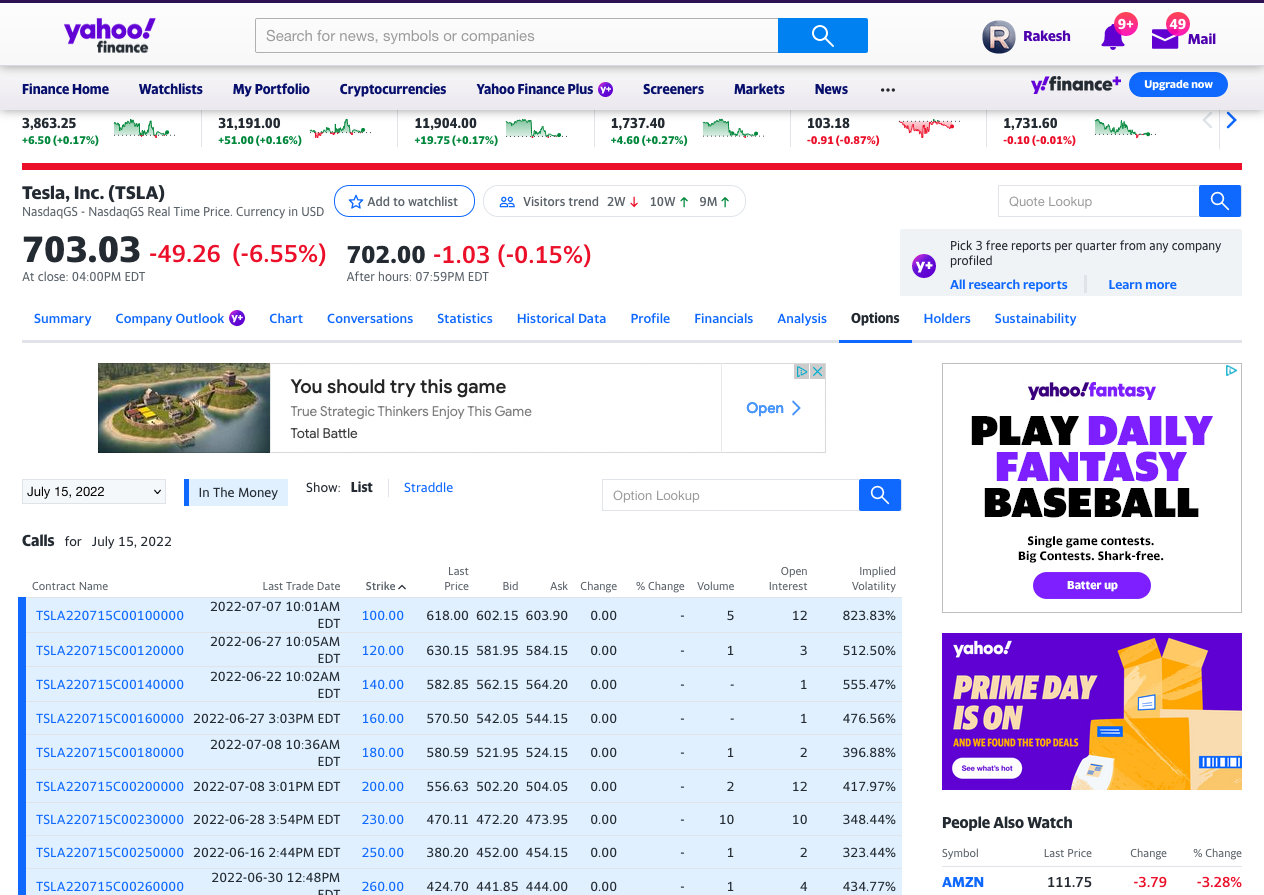

If we right-click and select "View Page Source," we can inspect the source code to see if the JSON data is stored within a `<script>` tag. After some inspection, we can see that the options data is embedded within the `<script>` tag highlighted below, on line 238, after `root.App.main =`. We'll combine the use of BeautifulSoup with regular expressions to parse the contents of this `<script>` element.

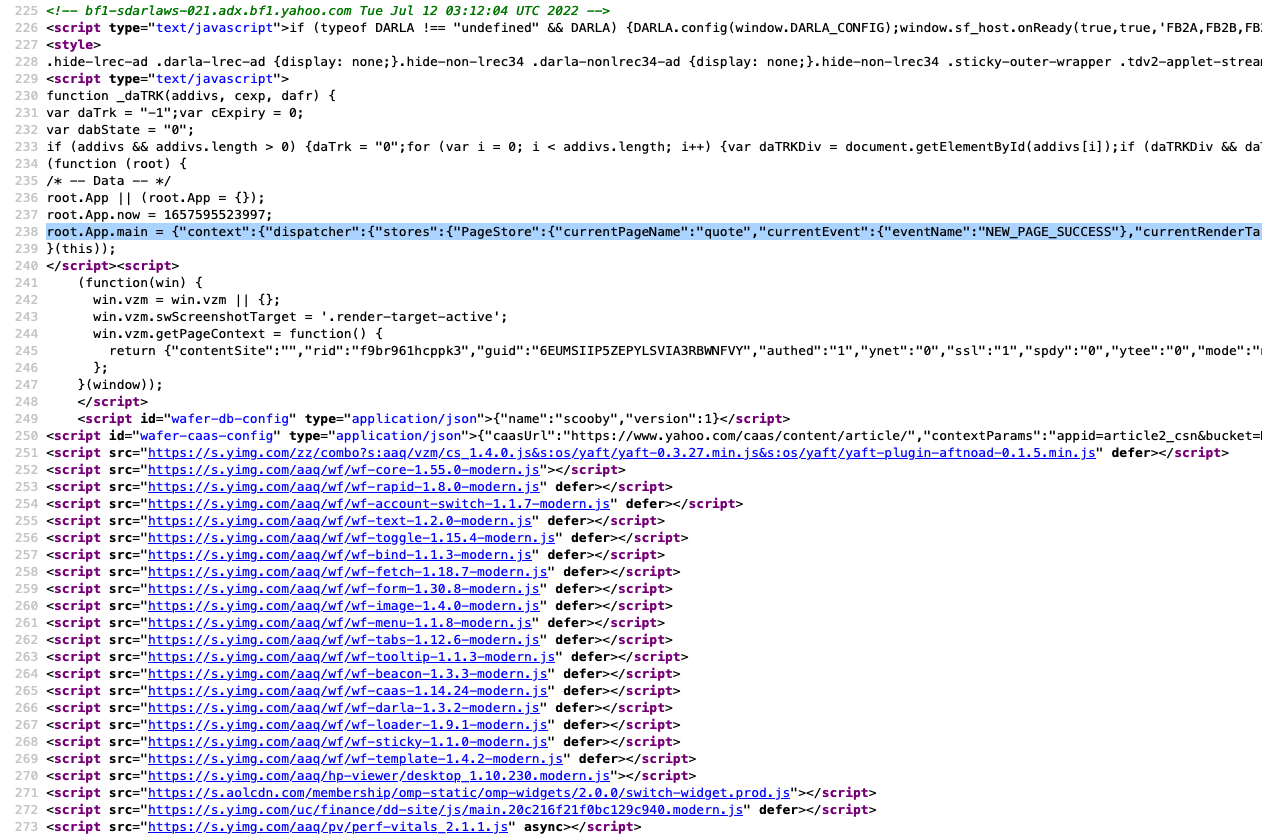

Now let's write a new function called `scrape_options_data()` to get the contents of the `<script>` tag and parse the JSON that it contains. The options data is located in a nested JSON dictionary within this `<script>` element.

In [22]:
def scrape_options_data(symbol):
    print("Scraping options data for: {}".format(symbol))

    # Set Yahoo! Finance URL
    url = "https://finance.yahoo.com/quote/{}/options?p={}".format(symbol, symbol)

    # Get random user agent
    ua = UserAgent()
    user_agent = ua.random

    # Set headers with random user agent
    headers = {
        'User-Agent': user_agent,
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'Referer': 'https://finance.yahoo.com/quote/{}/options?p={}'.format(symbol, symbol),
        'Origin': 'https://finance.yahoo.com',
        'Connection': 'keep-alive',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-site',
    }

    # Get BeautifulSoup object
    soup = get_soup(url, headers)
    
    # Find desired <script> tag containing "root.App.main" text
    script = soup.find("script", text=re.compile("root.App.main")).text
    
    # Search for JSON dictionary using regex and capture groups
    data = json.loads(re.search("root.App.main\\s+=\\s+(\\{.*\\})", script).group(1))
    
    # Get data in "context"->"dispatcher"->"stores"
    stores = data["context"]["dispatcher"]["stores"]
    
    # Get calls data in "OptionContractsStore"->"contracts"->"calls"
    calls_data = stores["OptionContractsStore"]["contracts"]["calls"]

    # Get puts data in "OptionContractsStore"->"contracts"->"puts"
    puts_data = stores["OptionContractsStore"]["contracts"]["puts"]
    
    # Normalize JSON and save to DataFrame
    calls = pd.json_normalize(calls_data, max_level=1)
    puts = pd.json_normalize(puts_data, max_level=1)
    
    # Write DataFrame to CSV file
    calls.to_csv("calls-data-{}.csv".format(symbol))
    puts.to_csv("puts-data-{}.csv".format(symbol))

    print("Scraping completed")

Some observations:
* First, we set our URL and header variables and get our BeautifulSoup object.
* Next, we use the BeautifulSoup `find()` method to locate the `<script>` tag containing the relevant data.
* We search for the `<script>` tag containing the text "root.App.main" by passing this into the `text` parameter of the `find()` method, and extract the text from the resulting BeautifulSoup object.
* Then, we use regex to specifically extract the JSON content from the text of the `<script>` object.
    * The `re.search()` function enables us to search for the the required content and extract it using capture groups.
    * Our data is located in the second capture group (capture group 1), so we select it using `group(1)` on the match object resulting from `re.search()`.
    * We feed this into the `json.loads()` function to extract the JSON dictionary and save it as the variable `data`.
* We extract the nested dictionary containing the relevant data, which is located under the key sequence "context"->"dispatcher"->"stores."
    * We still need to find our required field, the options data, which is a nested JSON dictionary located further down under the key sequence "OptionContractsStore"->"contracts"->"calls."
* Finally, we use the pandas `json_normalize()` function to normalize the JSON, since it contains multiple-key sequences for each variable of options data, and save it to a pandas DataFrame.
    * The resulting DataFrame is written to a CSV file.

Now, we can run our program to scrape the data.

In [23]:
symbol = "TSLA"
scrape_options_data(symbol)

Scraping options data for: TSLA
Scraping completed


Let's take a look at the output of our CSV file to see if we got the correct data.

In [24]:
calls = pd.read_csv("calls-data-TSLA.csv")
puts = pd.read_csv("puts-data-TSLA.csv")
calls = calls.iloc[:, 1:]
puts = puts.iloc[:, 1:]

In [25]:
len(calls)

210

In [26]:
len(puts)

202

In [27]:
calls.dtypes

contractSymbol            object
currency                  object
contractSize              object
inTheMoney                  bool
impliedVolatility.raw    float64
impliedVolatility.fmt     object
expiration.raw             int64
expiration.fmt            object
expiration.longFmt        object
change.raw                 int64
change.fmt               float64
strike.raw               float64
strike.fmt                object
lastPrice.raw            float64
lastPrice.fmt            float64
openInterest.raw           int64
openInterest.fmt           int64
openInterest.longFmt       int64
percentChange.raw          int64
percentChange.fmt         object
ask.raw                  float64
ask.fmt                  float64
volume.raw               float64
volume.fmt                object
volume.longFmt            object
lastTradeDate.raw          int64
lastTradeDate.fmt         object
lastTradeDate.longFmt     object
bid.raw                  float64
bid.fmt                  float64
dtype: obj

In [28]:
puts.dtypes

contractSymbol            object
currency                  object
contractSize              object
inTheMoney                  bool
impliedVolatility.raw    float64
impliedVolatility.fmt     object
expiration.raw             int64
expiration.fmt            object
expiration.longFmt        object
change.raw                 int64
change.fmt               float64
strike.raw               float64
strike.fmt                object
lastPrice.raw            float64
lastPrice.fmt             object
openInterest.raw           int64
openInterest.fmt           int64
openInterest.longFmt       int64
percentChange.raw          int64
percentChange.fmt         object
ask.raw                  float64
ask.fmt                   object
volume.raw               float64
volume.fmt                object
volume.longFmt            object
lastTradeDate.raw          int64
lastTradeDate.fmt         object
lastTradeDate.longFmt     object
bid.raw                  float64
bid.fmt                   object
dtype: obj

In [29]:
calls.head()

,contractSymbol,currency,contractSize,inTheMoney,impliedVolatility.raw,impliedVolatility.fmt,expiration.raw,expiration.fmt,expiration.longFmt,change.raw,...,ask.raw,ask.fmt,volume.raw,volume.fmt,volume.longFmt,lastTradeDate.raw,lastTradeDate.fmt,lastTradeDate.longFmt,bid.raw,bid.fmt
0,TSLA220715C00100000,USD,REGULAR,True,0.00001,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,5.0,5,5,1657202474,2022-07-07,2022-07-07T14:01,0.0,0.0
1,TSLA220715C00120000,USD,REGULAR,True,0.00001,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,1.0,1,1,1656338708,2022-06-27,2022-06-27T14:05,0.0,0.0
2,TSLA220715C00140000,USD,REGULAR,True,0.00001,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,NaN,NaN,NaN,1655906547,2022-06-22,2022-06-22T14:02,0.0,0.0
3,TSLA220715C00160000,USD,REGULAR,True,0.00001,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,NaN,NaN,NaN,1656356582,2022-06-27,2022-06-27T19:03,0.0,0.0
4,TSLA220715C00180000,USD,REGULAR,True,0.00001,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,1.0,1,1,1657290987,2022-07-08,2022-07-08T14:36,0.0,0.0


In [30]:
puts.head()

,contractSymbol,currency,contractSize,inTheMoney,impliedVolatility.raw,impliedVolatility.fmt,expiration.raw,expiration.fmt,expiration.longFmt,change.raw,...,ask.raw,ask.fmt,volume.raw,volume.fmt,volume.longFmt,lastTradeDate.raw,lastTradeDate.fmt,lastTradeDate.longFmt,bid.raw,bid.fmt
0,TSLA220715P00100000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.00,63.0,63,63,1657555076,2022-07-11,2022-07-11T15:57,0.0,0.00
1,TSLA220715P00120000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.00,25.0,25,25,1657569476,2022-07-11,2022-07-11T19:57,0.0,0.00
2,TSLA220715P00140000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.00,3.0,3,3,1657546826,2022-07-11,2022-07-11T13:40,0.0,0.00
3,TSLA220715P00160000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.00,376.0,376,376,1657131317,2022-07-06,2022-07-06T18:15,0.0,0.00
4,TSLA220715P00180000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.00,223.0,223,223,1657555115,2022-07-11,2022-07-11T15:58,0.0,0.00


In [31]:
calls.tail()

,contractSymbol,currency,contractSize,inTheMoney,impliedVolatility.raw,impliedVolatility.fmt,expiration.raw,expiration.fmt,expiration.longFmt,change.raw,...,ask.raw,ask.fmt,volume.raw,volume.fmt,volume.longFmt,lastTradeDate.raw,lastTradeDate.fmt,lastTradeDate.longFmt,bid.raw,bid.fmt
205,TSLA220715C02200000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,500.0,500,500,1657040981,2022-07-05,2022-07-05T17:09,0.0,0.0
206,TSLA220715C02250000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,2.0,2,2,1656340712,2022-06-27,2022-06-27T14:38,0.0,0.0
207,TSLA220715C02300000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,3.0,3,3,1657308420,2022-07-08,2022-07-08T19:27,0.0,0.0
208,TSLA220715C02350000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,1.0,1,1,1657546205,2022-07-11,2022-07-11T13:30,0.0,0.0
209,TSLA220715C02400000,USD,REGULAR,False,0.500005,50.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.0,0.0,2.0,2,2,1657546201,2022-07-11,2022-07-11T13:30,0.0,0.0


In [32]:
puts.tail()

,contractSymbol,currency,contractSize,inTheMoney,impliedVolatility.raw,impliedVolatility.fmt,expiration.raw,expiration.fmt,expiration.longFmt,change.raw,...,ask.raw,ask.fmt,volume.raw,volume.fmt,volume.longFmt,lastTradeDate.raw,lastTradeDate.fmt,lastTradeDate.longFmt,bid.raw,bid.fmt
197,TSLA220715P02125000,USD,REGULAR,True,0.000010,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,1080.30,"1,080.30",NaN,NaN,NaN,1639371626,2021-12-13,2021-12-13T05:00,1070.80,"1,070.80"
198,TSLA220715P02150000,USD,REGULAR,True,0.000010,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,0.00,0.00,3.0,3,3,1656599630,2022-06-30,2022-06-30T14:33,0.00,0.00
199,TSLA220715P02300000,USD,REGULAR,True,0.000010,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,1541.65,"1,541.65",NaN,NaN,NaN,1643121167,2022-01-25,2022-01-25T14:32,1531.45,"1,531.45"
200,TSLA220715P02350000,USD,REGULAR,True,0.000010,0.00%,1657843200,2022-07-15,2022-07-15T00:00,0,...,1450.15,"1,450.15",40.0,40,40,1648474473,2022-03-28,2022-03-28T13:34,1444.90,"1,444.90"
201,TSLA220715P02400000,USD,REGULAR,True,9.079838,907.98%,1657843200,2022-07-15,2022-07-15T00:00,0,...,1751.10,"1,751.10",4.0,4,4,1652976682,2022-05-19,2022-05-19T16:11,1748.70,"1,748.70"


We can see that the options data has been correctly scraped and saved to the CSV files. The `json_normalize()` function enabled us to flatten the JSON dictionary and create additional columns with the appropriate key appended to the variable name as a suffix following a period.